# Refining Models
### This notebook will be used to explain the algorithms used in the Solicitation Review Tool, including explanation of the model parameters and documentation about optimization efforts

#### Load Data
First, we will load the data. For the purpose of this explanation, we will be using a binary classifier, but you can as easily get the three-way classifier by leaving out the convert_to_binary step in cell one and setting dataDict=raw

In [2]:
from sklearn.externals import joblib
import dataHandling
import matplotlib.pyplot as plt

raw = joblib.load('binaries/dataDump_20161122.pkl')
dataDict = dataHandling.convert_to_binary(raw)


Now that we have our data, let's have a look at it

In [2]:
dataDict.keys()

dict_keys(['description', 'target_names', 'DESCR', 'data', 'target'])

The dataDict object is a dictionary. 'description' is a simple description of the dataset. 'target' is a list of integer values (in this case, 1 or 0) representing the grade assigned to each solicitation by its index. 'data' contains the tokenized, lemmatized text, which we will vectorize in the next step. the only other key to worry about is 'target_names', which contains only two values: RED and GREEN, which correspond to 0 and 1; these are the qualitative labels for the values in 'target' (since we need to pass in a vector of numbers for classification).

#### Prepare the data for classification
For this section, we will essentially be doing three things: vectorizing the data (turning the text data into a vector of numbers that can be used by the classifiers later). There are many ways to vectorize data, but we are using what's called a TF-IDF Vectorizer. 

When vectorizing text, one essentially wants to end up with a distribution showing the prevalence of different words within a given document. Using the more basic count vectorizer will yield a sparse matrix with a count of the number of times a given word occurred in a document. This, however, is not the best approach in all cases; for instance, when one is dealing with documents of varying lengths, using a simple count vectorizer could lead to problems where certain words might appear very often in a longer document, however the higher number of occurrences might not be an indication of how the document should be classified. The TF-IDF vectorizer accounts for document length, though; TF-IDF stands for 'Term Frequency Inverse Document Frequency', referring to the normalization step that was added to the count vectorizer. 

Scikit-Learn has a built-in TF-IDF vectorizer function built into its feature_extraction library. We will now import the TF-IDF vectorizer module and instantiate the vectorizer. A note on the parameters: 
* ```sublinear_tf``` is referring to sublinear term frequency, a parameter that uses a logarithm of term frequency instead of a count, since several occurrences of a word is not necessarily significant for our problem. 
* ```max_df``` refers to the maximum document frequency; in other words, if a word appears in more than a given percentage of documents, it will be ignored, as it's unlikely to be a significant predictor of anything. I've set the parameter to .5, so any words that appear in more than 50% of documents will be ignored during classification. 
* Although I've taken steps already to remove stopwords from the tokenized text, I'm also setting the ```stop_words``` parameter here to English, which will tell Scikit Learn to ignore any of the traditional English stopwords (a, an, the, it, what, etc). 

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

Now that we have the vectorizer in place, let's separate the data into train/test pieces. I built a function in dataHandling that will divide the dataset into two pieces. The second parameter of the function is the size of the test set; I've set it to .2 here, or 20% of the dataset, but that's not a hard and fast rule by any means.

Once you have the train/test sets, we will need to isolate the targets from the data; targets will be ```y```, while data will be ```X```, as it is with most mathematical functions in machine learning (we'll get to the math a bit later). Finally, we'll use the vectorizer on the data. Note that we're running ```fit_transform``` on the training data, but only ```transform``` on the test data; the vectorizer used for the training dataset will be the foundational vectorizer, and we need further vectorized texts to yield sparse matrices with the same shape as the matrix returned by vectorizing the training data; therefore ```X_test``` is being formed using the same vectorizer that was created with ```X_train```.

We'll also pull out categories and feature names, which will be used later on for things like printing the most informative features in certain models.

One final thing to note: our vectorized data is in a form known as a _sparse matrix_. Generally, a sparse matrix refers to a numerical matrix where the majority of the values are 0. Since there is an entry in the matrix for every word found in all documents, but since most words only appear in a handfull of documents, you will get a sparse matrix from a dataset such as this. This is not a problem at all, but you may find that some data science techniques don't work on sparse matrices.

In [4]:
data_train, data_test = dataHandling.make_train_test(dataDict, .2)
y_train, y_test = data_train['target'], data_test['target']
X_train = vectorizer.fit_transform(data_train['data'])
X_test = vectorizer.transform(data_test['data'])

categories = dataDict['target_names']
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

### Ridge Classifier
Now that we've prepared our data, it's time to start in on the classifiers. 

In writing this, I'm assuming the reader has at least some familiarity with basic regression analysis techniquest like Ordinary Least Squares regression; I'll therefore leave out explaining these concepts in detail and will instead focus on the algorithms I've found useful for this problem set. The first one we'll be trying out is the ```ridge``` classifier. 

Going back to OLS, you can think of our classification problem as a classic OLS regression problem. Let's refresh on the equation for an OLS regression model: 
$$ Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \epsilon $$
Y is the dependent variable, the thing we're trying to predict; in this case, it is whether a document should be classified as 'green' or 'red'. In our data, it is 'target', and it is a number between 0 and 1; the closer the number is to 1, the higher the probability that the document is going to be labeled 'GREEN'. Think of each X then being a word, and each $ \beta\ $ being the coefficient assigned to that word by the algorithm. Some words, in our case words like 508, accessibility, and GPAT, would probably have very high coefficients; if those words show up, the predicted score will increase by the amount of the coefficient. 

Essentially, what we're aiming for with OLS regression is $ \hat{\beta} $, the estimated coefficient that represents the closest measure of the theoretical $ \beta $ (for the population). When you have a dataset with a high degree of multicollinearity, or when your dataset has many possible parameters, OLS will not be the tool to reach for, as the model will be highly prone to over-fitting (the model's coefficients are very good at predicting values within the sample, but very bad at predicting new values introduced from outside the sample, referred to as the level of prediction error (PE)). What it essentially comes down to is that the coefficients will have a wide variance, but thanks to the [variance-bias tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html), we can introduce some parameter constraints; these constraints will introduce bias and reduce variance, making the coefficients more accurate at predicting out-of-sample data. This constraint is known as a penalty. Now let's try ridge regression and OLS regression on our train/test sets to measure their respective accuracies. 

First, though, a function for testing a classifier:

In [6]:
from sklearn import metrics
def trim(s):
    return s if len(s) <= 80 else s[:77] + "..."

def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    try:
        score = metrics.accuracy_score(y_test, pred)
    except:
        score = metrics.r2_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    return score

In [7]:
from sklearn.linear_model import LinearRegression

OLS = LinearRegression()
OLS.fit(X_train, y_train)
OLS_pred = OLS.predict(X_test)
metrics.r2_score(y_test, OLS_pred)

0.44929695397987324

Now, it's important to note here that OLS regression can't give us an accuracy score, per se, as it's not a classifier (classifiers return a 0-1 score for each category, while regressions output a number). I'm instead using the R-Squared value (AKA the coefficient of determination), an approximate measure of how well future samples are likely to be predicted by the model. At .45, it is pretty low (note that this number may differ slightly from what you see, as the train/test operation uses a random shuffle, so the dataset you're working with will be different from mine and the R-Squared will likely vary by +/-.3); essentially, this is saying that the model can account for about 43% of the variation in the sample, which gives us an idea of how well it will do in predicting new values from out of the sample.

With an OLS example as our baseline, let's try a ridge regression, which will add constraints on the parameters, introducing bias, but reducing variance. A note on the parameters: I've adjusted two of the ridge parameters away from their defaults for the purpose of improving accuracy. $ \alpha $ represents the regularization strength (i.e. the size of the penalty applied). The following code snippet is an attempt to find an optimal value for alpha:

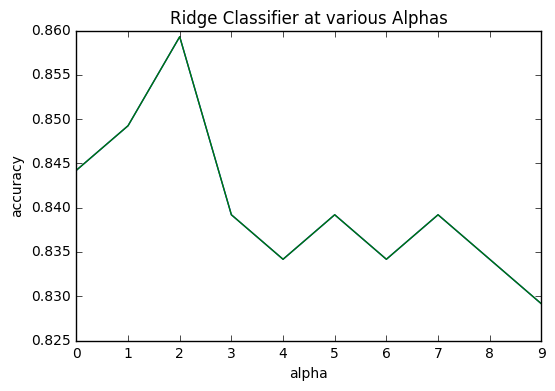

In [28]:
from sklearn.linear_model import RidgeClassifier
result = []
alpha = []
for i in range(0, 10):
    ridge = RidgeClassifier(alpha=i, solver="sag")
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    metrics.accuracy_score(y_test, ridge_pred)
    alpha.append(i)
    result.append(metrics.accuracy_score(y_test, ridge_pred))

plt.plot(alpha, result)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Ridge Classifier at various Alphas')
plt.show()

As we can see, the peak accuracy of $ \alpha $ is at $ \alpha $ = 2. This is the value we'll feed it for classification. The second parameter is the solver; SKLearn allows for about 6 different solvers, and I went with SAG (Stochastic Average Gradient descent); after testing others, SAG offers the highest measured accuracy levels, and it is generally the go-to solver when dealing with a large number of features. We'll get into Stochastic Gradient Descent soon. 

In [29]:
ridge = RidgeClassifier(alpha=2, solver="sag")
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
metrics.accuracy_score(y_test, ridge_pred)

0.85929648241206025

At nearly 86% accuracy, it would be safe to say that the Ridge model is a strong improvement over the OLS model. Let's now move into another linear model, Logistic Regression.

### Logistic Regression

So, what's the major difference between Logistic Regression and OLS? It's actually fairly simple: while OLS returns a continuous dependent variable Y, logistic regression instead returns a binary dependent variable Y: 1 or 0. How does it do this? It's essentially deriving a probability for each of two binary outcomes and returning the outcome with the highest probability. Here's the formula:
$$ P(Y=1) = \frac{1}{(1+e^{-(b_0 + \Sigma(b_iX_i)})} $$
Note that the exponent of $ e $ is the same basic equation as used in OLS regression. Logistic regression is sometimes referred to in machine learning as 'Maximum Entropy Classification', and it is one of the most popular algorithms used for Natural Language Processing (NLP) machine learning tasks.

In [38]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(solver = "sag")
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
metrics.accuracy_score(y_test, logit_pred)

0.83417085427135673

As with ridge regression, we're using the SAG solver. The model's accuracy with our current test/train sets is around 83%, not a bad outcome. Now let's try another technique: Perceptron

### Perceptron
The perceptron algorithm is another linnear classifier based on an early machine produced for image recognition in the 1950's. It is one of the earliest forms of a neural network (SKLearn doesn't currently support more complex neural networks, so it is not going to be used here). The basic workings of the perceptron algorithm are similar to the logistic regression equation, however perceptron classifiers, instead of weighing the uncertainty of the outcome probabilities (in the way logistic regression does), essentially draw a linnear boundary and classify points based on their position in relation to the boundary. As new observations are added, the algorithm examines their position relative to the boundary that was drawn; if the observation is on the expected side of the boundary (i.e. the prediction is correct), the model will do nothing and move on to the next observation. If the observation is on the wrong side of the line, however, the model will add or subtract the observation's feature vector from the weight; when this happens enough times, the boundary line's position may change. This is an iterative process, so let's test the model to see how many iterations it will take to get to the optimal point.

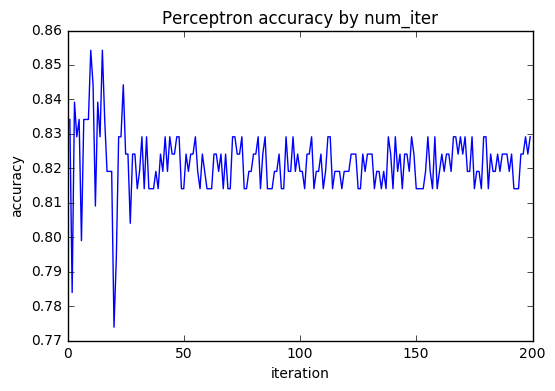

10
15


In [52]:
from sklearn.linear_model import Perceptron
acc = []
iterations = []
for i in range(1, 200):
    perceptron = Perceptron(n_iter=i)
    perceptron.fit(X_train, y_train)
    perceptron_pred = perceptron.predict(X_test)
    iterations.append(i)
    acc.append(metrics.accuracy_score(y_test, perceptron_pred))
    
plt.plot(iterations, acc)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('Perceptron accuracy by num_iter')
plt.show()

for i, a in enumerate(acc):
    if a == max(acc):
        print(iterations[i])
    

Setting the number of iterations to 200, we can see that the maximum accuracy scores appear early in the iterations. Note, however, that there is also wide variance in acuracy toward the beginning; since we are shuffling the data for train/test, we can't pick a single point in the iterations and count on that being the magic number forever, as a new dataset might have that iteration with a very low accuracy score. Therefore, let's set the number of iterations at a value around where we see equilibrium being reached: 50. 

In [54]:
perceptron = Perceptron(n_iter=50)
perceptron.fit(X_train, y_train)
perceptron_pred = perceptron.predict(X_test)
metrics.accuracy_score(y_test, perceptron_pred)

0.81407035175879394

At 81% accuracy, the perceptron classifier is passing our acceptable threshold of 80%. As new data becomes available, expect this to increase.

### Passive-Aggressive Classifier

The passive-aggressive classifier is a sort of streaming classifier model that is ideal for handling large datasets, especially documents/text. Remember that with text classification, we are starting with a vector of values (words and their relative frequencies), then assigning them weights as we examine the relationships between the vectors and the labels. 

The passive-aggressive classifier starts with a vector of 0 weights. These weights are used to form a decision boundary, which can be represented linnearly. The algorithm then begins cycling through the observations from the dataset, comparing each obersvation's value against its position relative to the decision boundary. If the observation is on the correct side of the decision boundary, the algorithm will pass on to the next observation. If the observation is on the wrong side of the decision boundary, the weights are penalized to account for the incorrect observation. The algorithm then dumps that observation and repeats the process for the next one. It is called passive-aggressive because that describes the algorithm's behavior: if the classifier is correct, it will pass, while if it is incorrect, it will penalize the weights. 

The passive-aggressive classifier is also iterative, so let's see how many iterations it takes to get to a decently high score with little variation among iterations. 

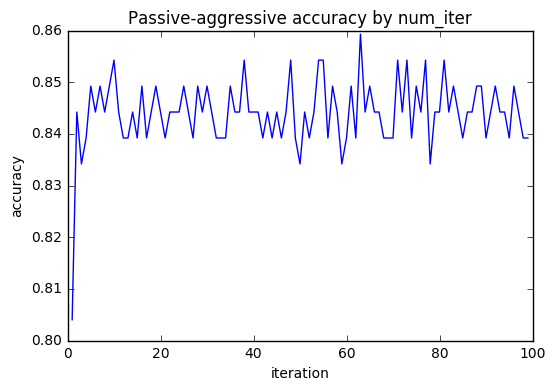

63


In [58]:
from sklearn.linear_model import PassiveAggressiveClassifier

acc = []
iterations = []
for i in range(1, 100):
    pa = PassiveAggressiveClassifier(n_iter=i)
    pa.fit(X_train, y_train)
    pa_pred = pa.predict(X_test)
    iterations.append(i)
    acc.append(metrics.accuracy_score(y_test, pa_pred))

plt.plot(iterations, acc)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('Passive-aggressive accuracy by num_iter')
plt.show()

for i, a in enumerate(acc):
    if a == max(acc):
        print(iterations[i])

As we can see from above, there's not a huge gain to be had from going over about 20 iterations here; the classifier accuracy levels out at between 84-85% after about 5 iterations, and a clear equilibrium is reached soon after. In order to minimize compute time, let's leave iterations at 20 for now. This will give us something like 84-85% accuracy, which is acceptable. We'll also apply the hinge loss function (refers to the method the algorithm uses for assigning weights in the penalty section).

In [76]:
pa = PassiveAggressiveClassifier(n_iter=20, loss = 'hinge')
pa.fit(X_train, y_train)
pa_pred = pa.predict(X_test)
metrics.accuracy_score(y_test, pa_pred)

0.84422110552763818

### K Nearest Neighbors Classifier

The K Nearest Neighbors Classifier (hereafter KNN) is based on what is known as a similarity function; essentially, observations are classified in relation to their 'neighbors', and the classification of any particular observation is based on how similar or different that observation is from its neighbors. In a linnear sense, imagine plotting two variables on an x/y axis. Let's say, for example, that we're measuring weight vs height for men and women. Here's an example dataset and plot:

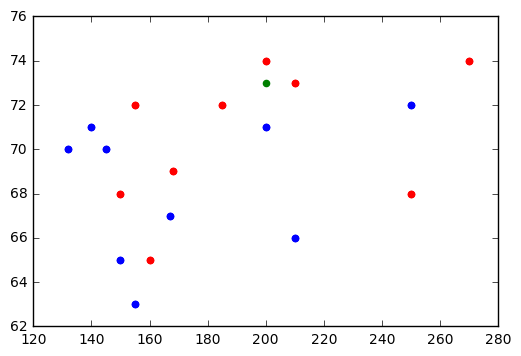

In [80]:
men_weight = [150, 155, 168, 200, 185, 210, 250, 270, 160]
men_height = [68, 72, 69, 74, 72, 73, 68, 74, 65]
women_weight = [150, 145, 167, 200, 132, 140, 210, 250, 155]
women_height = [65, 70, 67, 71, 70, 71, 66, 72, 63]
unk_weight = [200]
unk_height = [73]
plt.scatter (men_weight, men_height, color = 'red')
plt.scatter (women_weight, women_height, color = 'blue')
plt.scatter(unk_weight, unk_height, color = 'green')
plt.show()

In this example, we have a plot of men's vs. women's weights and heights. The green dot is our unknown person, and we are trying to guess the person's gender based on their weight and height alone. In KNN classification, we will look at the nearest neighbors on this scatter plot and determine the unknown person's gender based on their position in relation to the people whose gender we know. If we choose to look at just one neighbor, there is a male with fairly similar weight/height, so we might classify the unknown person as a male. If we took the three nearest neighbors, one is female and two are male, so we would classify male, but with a degree of uncertainty. You should always use an odd number of neighbors in case there is an even split in the classification (e.g. two equidistant neighbors, one being male and the other female).

With that in mind, let's apply KNN to our classification problem. We'll start by trying to find out the optimal number of neighbors to use

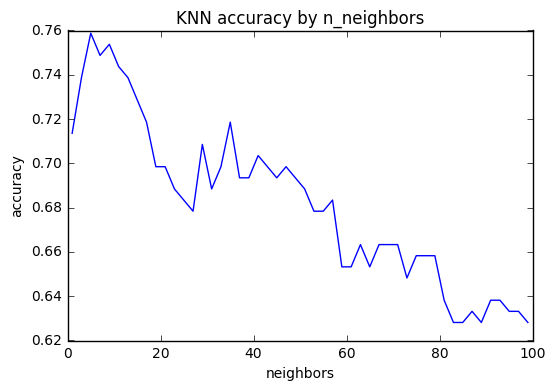

5


In [83]:
from sklearn.neighbors import KNeighborsClassifier
acc = []
neighbors = []
for i in range(1, 100, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    neighbors.append(i)
    acc.append(metrics.accuracy_score(y_test, knn_pred))

plt.plot(neighbors, acc)
plt.xlabel('neighbors')
plt.ylabel('accuracy')
plt.title('KNN accuracy by n_neighbors')
plt.show()

for i, a in enumerate(acc):
    if a == max(acc):
        print(neighbors[i])

Here, we can see that increasing the number of neighbors leads to decreased accuracy, and an equilibrium isn't reached. The maximum score for KNN here is at 5 neighbors, so we'll go with that, although the accuracy is still not great at just 76%. 

In [91]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
metrics.accuracy_score(y_test, knn_pred)

0.75879396984924619

### Nearest Centroid Classifier

The nearest centroid classifier is similar to the KNN classifier in many ways. In text analytics, it's more often called the 'Rocchio' Classifier due to its similarity to the Rocchio algorithm. 

The biggest difference between the KNN classifier and the Nearest Centroid classifier is that while the KNN classifier looks to a specified number of neighbors to classify a point, Nearest Centroid classifiers take the mean values (centroids) of each class and assign a label to the new observation based on the distance between the observation's value and the values of the centroids. Let's say we had the following sets of numbers:

In [96]:
x = [1, 2, 3, 4, 5]
y = [11, 12, 13, 14, 15]

x_mean = np.mean(x)
y_mean = np.mean(y)

print('x_mean = ' + str(x_mean))
print('y_mean = ' + str(y_mean))

x_mean = 3.0
y_mean = 13.0


Now, say that our next observation is 7. The distance between x_mean and 7 is 4, while the distance between y_mean and 7 is 6; in this case, the observation would be classified in group x.

In [99]:
from sklearn.neighbors import NearestCentroid
nearestCentroid = NearestCentroid()
nearestCentroid.fit(X_train, y_train)
nc_pred = nearestCentroid.predict(X_test)
metrics.accuracy_score(y_test, nc_pred)

0.75376884422110557

75% accuracy is not great, and there unfortunately aren't many options for optimizing this algorithm when using a sparse matrix. 

### Linear Support Vector Classification

Linear Support Vector Classification (SVC) is a subset of what is known as Support Vector Machines (SVM). In essence, a Support Vector Machine works in a similar way to the Passive Aggressive and perceptron classifiers above, though with some notable differences. It is similar in that it constructs a decision threshold and classifies points in relation to that decision threshold, but different in that SVMs aim to maximize the _margin_ between the points and the decision boundary. For instance, let's plot some arbitrary points that illustrate this idea.

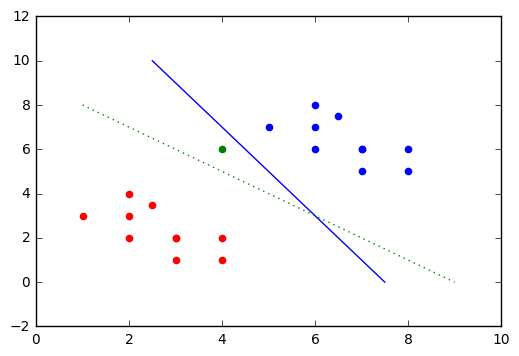

In [133]:
red_x = [2, 2, 3, 4, 2, 3, 1, 3, 4, 2.5]
red_y = [3, 2, 2, 2, 4, 2, 3, 1, 1, 3.5]

blue_x = [6, 6, 7, 8, 6, 7, 5, 7, 8, 6.5]
blue_y = [7, 6, 6, 6, 8, 6, 7, 5, 5, 7.5]

green_x = [4]
green_y = [6]

line_a_x = [10, 8, 6, 4, 2, 0]
line_a_y = [2.5, 3.5, 4.5, 5.5, 6.5, 7.5]

line_b_x = [8, 6, 4, 2, 0]
line_b_y = [1, 3, 5, 7, 9]

plt.scatter(red_x, red_y, color = 'red')
plt.scatter(blue_x, blue_y, color = 'blue')
plt.scatter(green_x, green_y, color = 'green')
plt.plot(line_a_y, line_a_x)
plt.plot(line_b_y, line_b_x, linestyle = 'dotted')
plt.show()

In this example, we have a decision boundary represented by the solid line. A perceptron or Passive-Aggressive classifier might yield such a line. This is a fine boundary and would classify most points correctly, but what about the green point? It's closer to the blue group and probably would have a true classification of blue. An SVM classifier would aim for a line more like the dotted line in this example; instead of just finding a line that separates the classes of points, SVM also aims to maximize the distance between the line and each set of points, precisely to avoid the type of mis-classification we saw with the green point. What ends up being created is called a _hyperplane_. The equation for the hyperplane is:

$$ f(x) = \beta_0 + \beta^{t}x $$

Where $ \beta $ is the weight vector and $ \beta_0 $ is the bias. $ x $ represents the feature vectors closest to the hyperplane (known as support vectors), and the position of the hyperplane is determined by adjustments tot the weight vectors and bias terms.

So, it may seem confusing now to distinguish between SVM, Perceptron, and Passive-aggressive classifiers. Here are a couple of points that help one understand the difference. 
* Since the passive-aggressive classifier changes the decision boundary to correctly classify the last observation introduced, changes to weight are not constant and depend on the size of the difference between the last point introduced and the previous decision boundary. This can be problematic, as it makes the PA classifier less accurate with noisy datasets.
* While the Pereceptron and SVM classifiers both adjust the decision boundary with constant weight changes, only the SVM aims to maximize the margin between the groups, which generally leads to more accurate classification with out-of-sample data.

Now that we have an idea of what an SVM is, let's turn our focus back to text classification and the Linear Support Vector Classifier model we're going to employ. Here, we're going to deploy a Linear SVC model using the squared hinge loss function. It's not important here to understand the mechanics of the squared hinge loss function, but do note here what a loss function is: a loss function defines the equation used for adjusting the decision function when data is mis-classified. Squared hinge loss functions are the most commonly used loss functions for SVM classifiers. We're going to use the l1 penalty here, which is our regularization term. Remember from ridge regression that we applied a penalty term to the linear model to reduce variance and avoid overfitting. Similarly, we can introduce a penalty here to account for the large number of terms we're dealing with for text classification (remember, sparse matrix). There are two penalties available, and we'll be using both. 'dual' is set to False here; this is to determine whether a dual or primal optimization problem will be solved. It's not important to understand that here, but note that dual has to be set to False if using the l1 penalty and squared hing loss function. 

In [138]:
from sklearn.svm import LinearSVC
L1SVC = LinearSVC(loss='squared_hinge', penalty='l1', dual = False)
L1SVC.fit(X_train, y_train)
L1SVC_pred = L1SVC.predict(X_test)
metrics.accuracy_score(y_test, L1SVC_pred)

0.87939698492462315

87% is not bad, far above our threshold. Now let's try the same function with the l2 loss function instead.

In [139]:
L2SVC = LinearSVC(loss='squared_hinge', penalty='l2', dual = False)
L2SVC.fit(X_train, y_train)
L2SVC_pred = L2SVC.predict(X_test)
metrics.accuracy_score(y_test, L2SVC_pred)

0.84422110552763818

84% is also an acceptable level of accuracy here. We can use this function as part of our algorithm set.

### Stochastic Gradient Descent

Our next set of classifiers uses a linear model similar to the SVM classifiers and logistic regression classifiers, but employs a technique known as gradient descent. The basic formula for gradient descent is: 
$$ b = a - \gamma \nabla F(a) $$
This basically represents a minimization function. Many examples explaining gradient descent use a hill climbing analogy (aiming to climb the hill in as few steps as possible), though, for our case, it's actually a hill descending analogy (since we're aiming for minimization). Here, $ a $ is the current position and $ b $ is the next position. $ \nabla F(a) $ represents the gradient, or the direction of steepest ascent (since we're looking to minimize the steps needed to reach the summit, we want to find the direction with the steepest gradient; since we have a $ - $ sign, the equation becomes for descent instead of ascent). $ \gamma\  $ represents a weighting factor that we will come back to later.

One problem with using gradient descent is that the gradient function can be extremely memory-intensive to run, especially to run iteratively over a large dataset; it requires computing a loss function for every observation several times over. Stochastic gradient descent solves this problem by essentially making an estimate of the gradient function by computing the loss function over a small random sample of the training data. The computed gradient is often wrong, but by iterating over the dataset several times, we eventually come to an accurate gradient. 

Let's go back to thinking of gradient descent vs. stochastic gradient descent in terms of climbing a hill. Climber A is aiming to climb the hill with as few steps as possible; this will require a lot of planning. The climber will spend time examining topographic maps and finding the path up the hill that allows them to ascend the highest distance with the fewest steps, and the steps they will take will have to be long and slow. While climber A is planning their route, though, climber B eschews the map entirely and starts walking up the hill, taking smaller and faster steps. Sure, they will almost certainly take more steps to get up the hill, and some of their steps might end up being in the wrong direction, but they will probably have ascended to the summit before climber A finishes mapping their route. That's about the best analogy for Stochastic Gradient Descent I can think of.

Let's run the SGD algorithm over our dataset now and see how it comes out at various numbers of iterations.

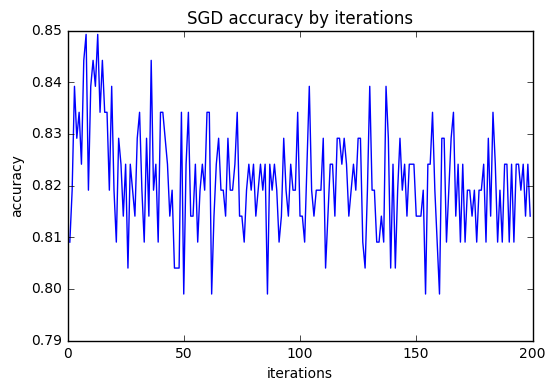

8
13


In [9]:
from sklearn.linear_model import SGDClassifier

acc = []
iterations = []
for i in range(1, 200):
    L1SGD = SGDClassifier(alpha=.0001, n_iter=i, penalty='L1')
    L1SGD.fit(X_train, y_train)
    L1SGD_pred = L1SGD.predict(X_test)
    iterations.append(i)
    acc.append(metrics.accuracy_score(y_test, L1SGD_pred))

plt.plot(iterations, acc)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('SGD accuracy by iterations')
plt.show()

for i, a in enumerate(acc):
    if a == max(acc):
        print(iterations[i])

So, we can see an initial peak; the top scores come at 8 and 13 iterations, but since this process involves random sampling, we can't count on these numbers as a consistent result. After running this several times, though, it becomes clear that the accuracy optimum is going to fall between 5 and 20 iterations. I'm therefore going to set iterations to 10 for the production model.

In [10]:
L1SGD = SGDClassifier(alpha=.0001, n_iter=10, penalty='L1')
L1SGD.fit(X_train, y_train)
L1SGD_pred = L1SGD.predict(X_test)
metrics.accuracy_score(y_test, L1SGD_pred)


0.83919597989949746

84% accuracy, not bad! This version of the classifier is using the l1 penalty